In [1]:
import pandas as pd
import numpy as np
from scipy.stats import binom

# Load the dataset
ratings = pd.read_csv("ratings.csv")

# INITIAL ANALYSIS
print(ratings.head())

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [2]:
# Number of ratings of consecutive movies
R_nr = ratings.groupby('movieId').size().reset_index(name='num_ratings')
print(R_nr['num_ratings'].value_counts().sort_index())

# we have many movies with very few ratings:
# 1 rating:   3446    5 above:    3268
# 2 ratings:  1298    10 above:   2121
# 3 ratings:  800     20 above:   1235
# 4 ratings:  530     30 above:   860
# 5 ratings:  382     40 above:   616

num_ratings
1      3446
2      1298
3       800
4       530
5       382
       ... 
278       1
279       1
307       1
317       1
329       1
Name: count, Length: 177, dtype: int64


In [3]:
# Unique movie ids and user ids
movieIds = ratings['movieId'].unique()
userIds = ratings['userId'].unique()

# Unique movie ratings
movieR = np.sort(ratings['rating'].unique())

In [4]:
# Function to split ratings into training and testing sets
def splitting(ratings):
    tr = pd.DataFrame(columns=ratings.columns)
    test = pd.DataFrame(columns=ratings.columns)

    for id in userIds:
        subset = ratings[ratings['userId'] == id]
        L = subset.shape[0]
        X = np.random.binomial(n=1, p=0.9, size=L)
        Ts = (X == 1)
        Fs = (X == 0)

        tr_t = subset[Ts]
        test_t = subset[Fs]

        tr = pd.concat([tr, tr_t], ignore_index=True)
        test = pd.concat([test, test_t], ignore_index=True)

    tr.to_csv("train_ratings.csv", index=False)
    test.to_csv("test_ratings.csv", index=False)


C:\Users\fiko1\AppData\Local\Temp\ipykernel_7336\1643836923.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tr = pd.concat([tr, tr_t], ignore_index=True)
C:\Users\fiko1\AppData\Local\Temp\ipykernel_7336\1643836923.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, test_t], ignore_index=True)


In [39]:
# REPLENISHING METHODS

# Method 0 Creates the matrix Z filled with zeros and the matrix T

def Z_0(tr, test, movieIds):
    n = tr['userId'].max()      # Number of users
    d = len(movieIds)           # Number of movies
    
    Z_m = np.zeros((n, d))      # Initialize Z.m matrix with zeros
    T_m = np.zeros((n, d))      # Initialize T.m matrix with zeros
    
    i = 0
    for id in movieIds:
        set_1 = tr[tr['movieId'] == id]
        set_2 = test[test['movieId'] == id]
        
        Z_m[set_1['userId'] - 1, i] = set_1['rating'].values
        T_m[set_2['userId'] - 1, i] = set_2['rating'].values
        
        i += 1
    
    return Z_m, T_m

In [125]:
# Method 1 Mixture of columns PDFs and user means

def Z_1(Z_m, movieR):
    n, d = Z_m.shape

    Z_fill = np.copy(Z_m)
    
    n_i = np.sum(Z_fill != 0, axis=1)
    n_j = np.sum(Z_fill != 0, axis=0)
    Z_i = np.sum(Z_fill, axis=1)
    
    R_avg = np.divide(Z_i, n_i, out=np.zeros_like(Z_i), where=n_i!=0)
    
    Z_T = Z_fill == 0
    
    for i in range(d):
        eq_0 = Z_T[:, i]
        L = np.sum(eq_0)
        
        if n - L < 30:
            Z_fill[eq_0, i] = R_avg[eq_0]
            continue
        
        freq = np.histogram(Z_m[~eq_0, i], bins=np.arange(len(movieR)+1))[0]
        p = freq / np.sum(freq)
        ranR = np.random.choice(movieR, size=L, p=p, replace=True)
        
        Z_fill[eq_0, i] = ranR
    
    return Z_fill


In [70]:
# Method 2 User/movie mean/median/mode

from scipy.stats import mode

def Z_2(Z_m):
    n, d = Z_m.shape
    
    n_i = np.sum(Z_m != 0, axis=1)
    n_j = np.sum(Z_m != 0, axis=0)
    Z_i = np.sum(Z_m, axis=1)
    Z_j = np.sum(Z_m, axis=0)
    
    Z_med_i = np.zeros_like(Z_i)
    Z_med_j = np.zeros_like(Z_j)
    Z_mod_i = np.zeros_like(Z_i)
    Z_mod_j = np.zeros_like(Z_j)
    
    Z_F = Z_m != 0
    global_mode = mode(Z_m[Z_F], axis=None).mode
   
    for i in range(n):
        ne0_i = Z_m[i, :] != 0
        m = mode(Z_m[i, ne0_i]).mode
        if np.isnan(m):
            Z_mod_i[i] = global_mode
            continue
        Z_med_i[i] = np.median(Z_m[i, ne0_i])
        Z_mod_i[i] = m
    
    for j in range(d):
        ne0_j = Z_m[:, j] != 0
        if np.sum(ne0_j) == 0:
            continue
        m = mode(Z_m[ne0_j, j]).mode
        if np.isnan(m):
            Z_mod_j[j] = global_mode
            continue
        Z_med_j[j] = np.median(Z_m[ne0_j, j])
        Z_mod_j[j] = m
    
    # User means
    Z_avg_i = np.tile((Z_i / n_i).reshape(-1, 1), (1, d))
    # Movie means
    Z_avg_j = np.tile(np.where(n_j == 0, 0, Z_j / n_j), (n, 1))
    
    # User medians
    Z_med_i = np.tile(Z_med_i.reshape(-1, 1), (1, d))
    # Movie medians
    Z_med_j = np.tile(Z_med_j.reshape(1, -1), (n, 1))
    
    # User modes
    Z_mod_i = np.tile(Z_mod_i.reshape(-1, 1), (1, d))
    # Movie modes
    Z_mod_j = np.tile(Z_mod_j.reshape(1, -1), (n, 1))
    
    Z_avg_i[Z_F] = Z_m[Z_F]
    Z_avg_j[Z_F] = Z_m[Z_F]
    Z_med_i[Z_F] = Z_m[Z_F]
    Z_med_j[Z_F] = Z_m[Z_F]
    Z_mod_i[Z_F] = Z_m[Z_F]
    Z_mod_j[Z_F] = Z_m[Z_F]
    
    return Z_avg_i, Z_avg_j, Z_med_i, Z_med_j, Z_mod_i, Z_mod_j


In [17]:
# Method 3 Global mean/median/mode

def Z_3(Z_m):
    Z_avg = np.copy(Z_m)
    Z_med = np.copy(Z_m)
    Z_mod = np.copy(Z_m)
    
    Z_F = Z_m != 0
    global_mean = np.mean(Z_m[Z_F])
    global_median = np.median(Z_m[Z_F])
    global_mode = mode(Z_m[Z_F], axis=None).mode
    
    Z_avg[~Z_F] = global_mean
    Z_med[~Z_F] = global_median
    Z_mod[~Z_F] = global_mode
    
    return Z_avg, Z_med, Z_mod


In [142]:
# Method 4 Average over sum of i-th row and j-th column

def Z_4(Z_m):
    Z_fill = np.copy(Z_m)
    n, d = Z_m.shape
    
    n_i = np.sum(Z_fill != 0, axis=1)
    n_j = np.sum(Z_fill != 0, axis=0)
    Z_i = np.sum(Z_fill, axis=1)
    Z_j = np.sum(Z_fill, axis=0)
    
    n_sum = np.add.outer(n_i, n_j)
    Z_sum = np.add.outer(Z_i, Z_j)
    
    Z_avg = (Z_sum - Z_fill) / n_sum
    
    Z_T = Z_fill == 0
    Z_fill[Z_T] = Z_avg[Z_T]
    
    return Z_fill


In [10]:
# Quality of the system: root-mean square error

def rmse(Z_m, T_m):
    T_ne0 = T_m != 0
    T_p = np.sum(T_ne0)
    return np.sqrt(np.sum((Z_m[T_ne0] - T_m[T_ne0]) ** 2) / T_p)


In [ ]:
# CODE
import warnings
warnings.filterwarnings('ignore')

# 100 repetitions of the experiment and rmse of each method

# Set seed
np.random.seed(8)

N = 100
rmse_df = pd.DataFrame({"RMSE": np.zeros(12*N), "Group": ""})

for i in range(1, N+1):
    # Call splitting function
    splitting(ratings)
    
    # Read train and test data
    tr = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/train_ratings.csv")
    test = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/test_ratings.csv")
    
    # Get Z.m and T.m matrices using Z.0 function
    Z_m, T_m = Z_0(tr, test, movieIds)
    
    # Call Z.1, Z.2, Z.3, Z.4 functions consecutively and calculate RMSE for each
    Z_m1 = Z_1(Z_m, movieR)
    Z_m2_avg_i, Z_m2_avg_j, Z_m2_med_i, Z_m2_med_j, Z_m2_mod_i, Z_m2_mod_j, = Z_2(Z_m)
    Z_m3_avg, Z_m3_med, Z_m3_mod = Z_3(Z_m)
    Z_m4 = Z_4(Z_m)
    
    # Update rmse_df
    rmse_df.iloc[i-1, :] = [rmse(Z_m, T_m), "Zeros"]
    rmse_df.iloc[i-1 + N*1, :] = [rmse(Z_m1, T_m), "PDFs"]
    rmse_df.iloc[i-1 + N*2, :] = [rmse(Z_m2_avg_i, T_m), "U. mean"]
    rmse_df.iloc[i-1 + N*3, :] = [rmse(Z_m2_avg_j, T_m), "M. mean"]
    rmse_df.iloc[i-1 + N*4, :] = [rmse(Z_m2_med_i, T_m), "U. median"]
    rmse_df.iloc[i-1 + N*5, :] = [rmse(Z_m2_med_j, T_m), "M. median"]
    rmse_df.iloc[i-1 + N*6, :] = [rmse(Z_m2_mod_i, T_m), "U. mode"]
    rmse_df.iloc[i-1 + N*7, :] = [rmse(Z_m2_mod_j, T_m), "M. mode"]
    rmse_df.iloc[i-1 + N*8, :] = [rmse(Z_m3_avg, T_m), "Gl. mean"]
    rmse_df.iloc[i-1 + N*9, :] = [rmse(Z_m3_med, T_m), "Gl. median"]
    rmse_df.iloc[i-1 + N*10, :] = [rmse(Z_m3_mod, T_m), "Gl. mode"]
    rmse_df.iloc[i-1 + N*11, :] = [rmse(Z_m4, T_m), "Cross mean"]
    
    print(i)

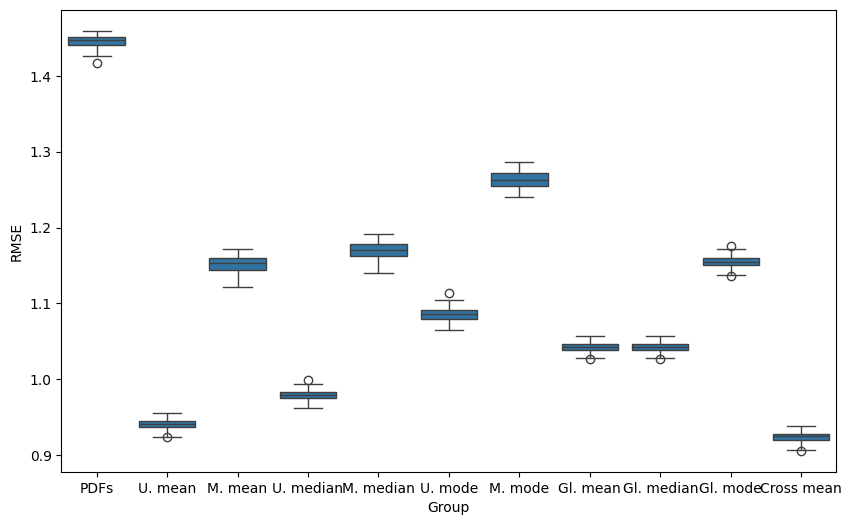

In [184]:
from matplotlib import pyplot as plt
import seaborn as sns

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=rmse_df[rmse_df["Group"] != "Zeros"], x="Group", y="RMSE")
# plt.show()
plt.savefig("boxplot.png")

In [198]:
def plot_boxplots(matrix, filename):
    plt.figure(figsize=(10, 6))
    plt.boxplot(matrix)
    plt.xlabel('Rank (r)')
    plt.ylabel('RMSE')
    plt.title('RMSE vs Rank (NMF)')
    plt.xticks(np.arange(1, matrix.shape[1] + 1))
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

In [ ]:
from sklearn.decomposition import NMF

np.random.seed(8)

N = 100
D = 40

rmse_nmf = np.zeros((N, D))

for i in range(1, N+1):
    splitting(ratings)
    tr = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/train_ratings.csv")
    test = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/test_ratings.csv")

    Z_m, T_m = Z_0(tr, test, movieIds)
    Z_m4 = Z_4(Z_m)
    
    for r in range(1, D+1):
        nmf_model = NMF(n_components=r, random_state=0)
        W = nmf_model.fit_transform(Z_m4)
        H = nmf_model.components_
        
        Z_approx = W.dot(H)
        rmse_nmf[i-1, r-1] = rmse(Z_approx, T_m)

        print(r)

    print(i)

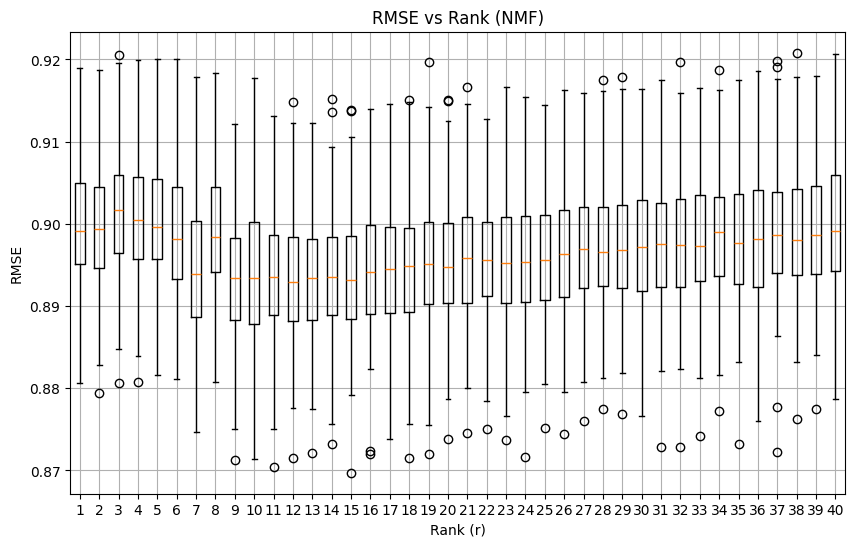

In [199]:
plot_boxplots(rmse_nmf, 'boxplot_nmf.png')

In [ ]:
from sklearn.decomposition import TruncatedSVD

np.random.seed(8)

N = 100
D = 25

rmse_svd = np.zeros((N, D))

for i in range(1, N+1):
    splitting(ratings)
    tr = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/train_ratings.csv")
    test = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/test_ratings.csv")

    Z_m, T_m = Z_0(tr, test, movieIds)
    Z_m4 = Z_4(Z_m)

    for r in range(1, D+1):
        svd_model = TruncatedSVD(n_components=r, random_state=42)
        svd_model.fit(Z_m4)
        Sigma2 = np.diag(svd_model.singular_values_)
        VT = svd_model.components_
        W = svd_model.transform(Z_m4) / svd_model.singular_values_
        H = np.dot(Sigma2, VT)
        
        Z_approx = np.dot(W, H)
        rmse_svd[i-1, r-1] = rmse(Z_approx, T_m)

        print(r)

    print(i)




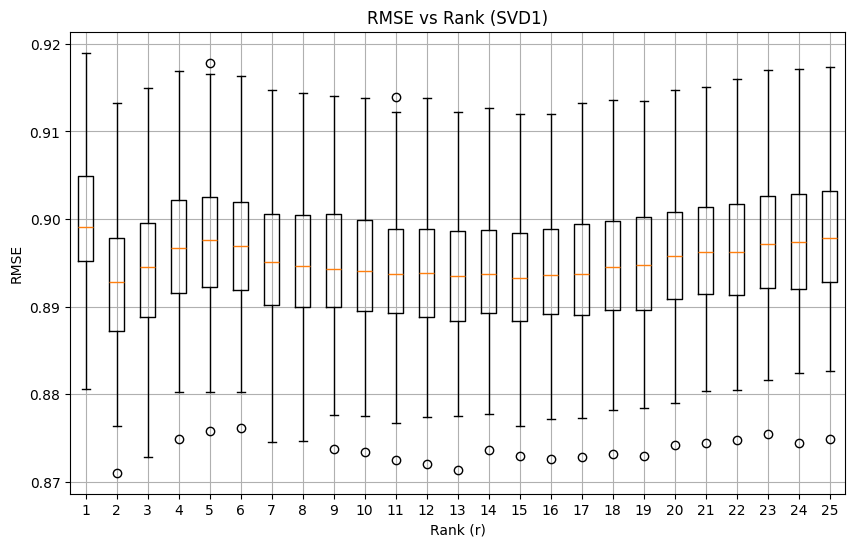

In [205]:
plt.figure(figsize=(10, 6))
plt.boxplot(rmse_svd)
plt.xlabel('Rank (r)')
plt.ylabel('RMSE')
plt.title('RMSE vs Rank (SVD1)')
plt.xticks(np.arange(1, rmse_svd.shape[1] + 1))
plt.grid(True)
plt.savefig('boxplot_svd1.png')
plt.show()

In [ ]:
np.random.seed(8)

N = 100
D = 10

rmse_svd2 = np.zeros((N, D))

for i in range(1, N+1):
    splitting(ratings)
    tr = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/train_ratings.csv")
    test = pd.read_csv("C:/Users/fiko1/Desktop/UWr/L2024/MoCaDR/Lab1/Projekt/test_ratings.csv")

    Z_m, T_m = Z_0(tr, test, movieIds)
    Z_m4 = Z_4(Z_m)

    for r in range(1, D+1):
        Z_F = Z_m != 0
        Z_T = Z_m == 0
        
        Z_approx = Z_m4.copy()
        d_rmse = 0.1
        rmse_temp1 = rmse(Z_m4, T_m)
        
        while d_rmse > 10**-2 or d_rmse > 1:
            svd_model = TruncatedSVD(n_components=r, random_state=42)
            svd_model.fit(Z_approx)
            U = svd_model.transform(Z_approx)
            Sigma = np.diag(svd_model.singular_values_)
            VT = svd_model.components_
            W = U / svd_model.singular_values_
            H = np.dot(Sigma, VT)
            
            Z_temp = np.dot(W, H)
            # We keep old ratings and fill the replenished terms with those from SVD
            Z_approx[Z_F] = Z_m[Z_F]
            Z_approx[Z_T] = Z_temp[Z_T]
            
            rmse_temp2 = rmse(Z_approx, T_m)
            d_rmse = rmse_temp1 - rmse_temp2
            rmse_temp1 = rmse_temp2
            
        rmse_svd2[i-1, r-1] = rmse(Z_approx, T_m)

        print(r)
    
    print(i)

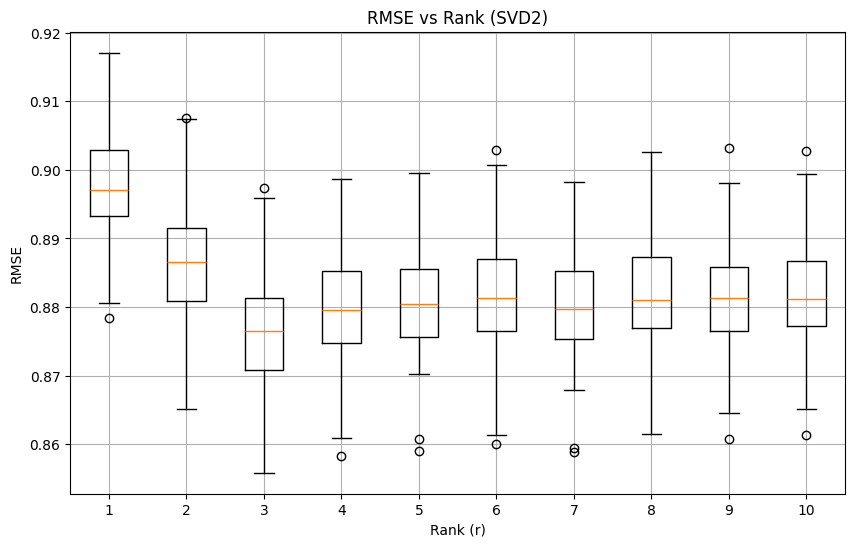

In [210]:
plt.figure(figsize=(10, 6))
plt.boxplot(rmse_svd2)
plt.xlabel('Rank (r)')
plt.ylabel('RMSE')
plt.title('RMSE vs Rank (SVD2)')
plt.xticks(np.arange(1, rmse_svd2.shape[1] + 1))
plt.grid(True)
plt.savefig('boxplot_svd2.png')
plt.show()